In [1]:
import numpy as np 
import pandas as pd
data= pd.read_csv("/Users/vanessaguerrier/Downloads/projet_TER/ner_dataset.csv",encoding="ISO-8859-1")

In [2]:
nb_sentence= data["Sentence #"].unique()
len(nb_sentence)

# id_begin_sentences = [data.index[data["Sentence #"] == x][0] for x in nb_sentence if pd.notna(x)]
# id_begin_sentences

47960

In [6]:
import torch 
X= data["Word"]
y= data["Tag"]
id2label = {i: label for i, label in enumerate(y)}

In [ ]:


from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
labels = y.unique()
num_labels = len(y.unique())

model = AutoModel.from_pretrained("bert-base-cased")

2026-02-11 12:33:38.625766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
text = "<model> ChronoNet-XL </model> is a novel deep learning architecture designed for sequential temporal data analysis, employing a hierarchical attention mechanism that allows for improved temporal resolution without excessive computational overhead. The model contains approximately <params> 4.2 billion </params> parameters and was trained on a heterogeneous cluster consisting of <num_hardware> 32 </num_hardware> <hardware> NVIDIA A100 GPUs </hardware> over a period of <trainning_time> 38 days </trainning_time>. The training was conducted in <country> Germany </country> in <year> 2023 </year>, leveraging mixed-precision training to optimize memory usage and speed. <model> ChronoNet-XL </model> demonstrates a remarkable capacity to model complex temporal dependencies, particularly in multivariate time-series applications. Its design emphasizes both efficiency and scalability, making it adaptable to industrial and research environments where data throughput is high. The training pipeline incorporated gradient checkpointing and dynamic learning rate schedules to maintain convergence stability. The model’s performance was benchmarked across multiple datasets, demonstrating consistent improvements in prediction accuracy and robustness under noisy conditions. While certain hyperparameters were optimized through grid search, others, such as dropout ratios in intermediate layers, remain under investigation. Early experiments indicate that scaling <model> ChronoNet-XL </model> beyond its current size could yield further improvements, though the computational costs are projected to increase non-linearly."

In [4]:
import re 

def decomposition_en_phrase(text):
    text = re.sub(r'\s*,\s*', ' , ', text)
    text = re.sub(r'\s*<\s*', ' <', text)
    text = re.sub(r'\s*>\s*', '> ', text)
    text= re.sub(r'\s*([;:])\s*', r' \1 ', text)
    phrases = re.split(r'(?<!\d)[.!?]+(?!\d)', text)
    phrases = [p.strip()+" ." for p in phrases if p.strip()]
    return phrases


def decomposition_en_list_mot(text):  # sourcery skip: for-append-to-extend, inline-immediately-returned-variable, list-comprehension
    phrases=decomposition_en_phrase(text)
    list_mot=[]
    for phrase in phrases:
        list_mot.append(phrase.split())
    return list_mot

def extraire_nom_balise(tag):
    return re.sub(r'[</>]', '', tag)


def labeliser(list_phrase):
    features = []
    labels = []
    for phrase in list_phrase:
        fe ,la = [],[]
        i = 0
        n = len(phrase)

        while i < n:
            token = phrase[i]
            if token.startswith("<") and not token.startswith("</"):
                nom = extraire_nom_balise(token)
                j = i + 1
                while j < n and not phrase[j].startswith("</"):
                    j += 1
                if j == n:
                    i += 1
                    continue
                taille = j - i - 1
                for k in range(taille):
                    mot = phrase[i + 1 + k]
                    fe.append(mot)
                    if k == 0:
                        la.append(f"B-{nom}")
                    else:
                        la.append(f"I-{nom}")
                i = j + 1
            else:
                fe.append(token)
                la.append("O")
            i += 1
        features.append(fe)
        labels.append(la)
    return features, labels

li=decomposition_en_list_mot(text)
fe,la=labeliser(li)
print(fe)

[['ChronoNet-XL', 'a', 'novel', 'deep', 'learning', 'architecture', 'designed', 'for', 'sequential', 'temporal', 'data', 'analysis', ',', 'employing', 'a', 'hierarchical', 'attention', 'mechanism', 'that', 'allows', 'for', 'improved', 'temporal', 'resolution', 'without', 'excessive', 'computational', 'overhead', '.'], ['The', 'model', 'contains', 'approximately', '4.2', 'billion', 'and', 'was', 'trained', 'on', 'a', 'heterogeneous', 'cluster', 'consisting', 'of', '32', 'NVIDIA', 'A100', 'GPUs', '</hardware>', 'over', 'a', 'period', 'of', '38', 'days'], ['The', 'training', 'was', 'conducted', 'in', 'Germany', '2023', 'leveraging', 'mixed-precision', 'training', 'to', 'optimize', 'memory', 'usage', 'and', 'speed', '.'], ['ChronoNet-XL', 'a', 'remarkable', 'capacity', 'to', 'model', 'complex', 'temporal', 'dependencies', ',', 'particularly', 'in', 'multivariate', 'time-series', 'applications', '.'], ['Its', 'design', 'emphasizes', 'both', 'efficiency', 'and', 'scalability', ',', 'making',

In [ ]:
inputs = tokenizer(text, return_tensors="pt")
print(inputs.word_ids())
with torch.no_grad():
    outputs = model(**inputs)


token_embeddings = outputs.last_hidden_state

print(token_embeddings.shape)


In [6]:
import os
def read_file_train(namefile):
    text=""
    with open(namefile, "r", encoding="utf-8") as file:
        for line in file:
            if line is not None :
                text += line+" " 
    return text


def read_all(lits_file_name):
    fe,la= [],[]
    for name in lits_file_name:
        text= read_file_train(name)
        text= decomposition_en_list_mot(text)
        features, labels= labeliser(text)
        print(len(features),len(labels))
        fe+=features
        la+= labels
    return fe ,la
    
li=["/Users/vanessaguerrier/Downloads/M2_TER/Nessa/train_file/chat-gpt.txt","/Users/vanessaguerrier/Downloads/M2_TER/Nessa/train_file/gemini.txt"]
f,l= read_all(li)

114 114
160 160


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    f,
    l,
    test_size=0.3,
    random_state=42
)

In [12]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))
print(X_test)

191 191
83 83
[['Due', 'to', 'the', 'massive', 'size', 'of', 'the', 'training', 'dataset', ',', 'mixed-precision', 'computations', 'and', 'gradient', 'accumulation', 'techniques', 'were', 'crucial', 'to', 'avoid', 'memory', 'bottlenecks', '.'], ['The', 'training', 'process', 'lasted', '115', 'days', ',', 'utilizing', 'a', 'sprawling', 'network', 'of', '4', ',', '096', 'Google', 'TPU', 'v5p', 'units', '.'], ['Mesa-Large', 'is', 'an', 'ambitious', 'project', 'aimed', 'at', 'creating', 'a', 'localized', 'AI', 'for', 'the', 'Southern', "Hemisphere's", 'unique', 'ecological', 'and', 'linguistic', 'landscape', '.'], ['The', 'duration', 'of', 'this', 'intensive', 'training', 'cycle', 'was', 'documented', 'at', '74', 'days', ',', 'during', 'which', 'the', 'system', 'ingested', 'over', '4', 'trillion', 'tokens', 'of', 'diverse', 'data', '.'], ['The', '50', 'billion', 'parameters', 'are', 'organized', 'into', 'a', 'hierarchical', 'structure', 'that', 'allows', 'the', 'model', 'to', 'process', 'b

In [ ]:
import requests
from io import BytesIO
from PyPDF2 import PdfReader

def read_pdf_from_url(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/112.0.0.0 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"Erreur lors du téléchargement : {response.status_code}")
    pdf_file = BytesIO(response.content)
    reader = PdfReader(pdf_file)
    text = ""
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text + "\n"
    return text

def remove_references(text):

    # Cherche le début après 'Abstract'
    abstract_keywords = ["Abstract", "ABSTRACT"]
    start_idx = 0
    for kw in abstract_keywords:
        idx = text.find(kw)
        if idx != -1:
            start_idx = idx + len(kw)
            break  # on prend le premier trouvé

    # Cherche la fin avant 'References' ou 'Bibliography'
    reference_keywords = ["References", "REFERENCES", "Bibliography", "BIBLIOGRAPHY"]
    end_idx = len(text)
    for kw in reference_keywords:
        idx = text.find(kw)
        if idx != -1:
            end_idx = idx
            break
    main_text = text[start_idx:end_idx].strip()
    return main_text

def read_file_test(lits_url):
    fe= []
    for url in lits_url:
        text = read_pdf_from_url(url)
        text = remove_references(text)
        text= decomposition_en_list_mot(text)
        fe+= text
    return fe

url = "https://archives.ismir.net/ismir2023/paper/000029.pdf"
texte = read_file_test([url])
print(texte)  


TIMBRE TRANSFER USING IMAGE-TO-IMAGE DENOISING
DIFFUSION IMPLICIT MODELS
Luca Comanducci Fabio Antonacci Augusto Sarti
Dipartimento di Elettronica, Informazione e Bioingegneria, Politecnico di Milano, Italy
luca.comanducci@polimi.it, fabio.antonacci@polimi.it, augusto.sarti@polimi.it
ABSTRACT
Timbre transfer techniques aim at converting the sound of
a musical piece generated by one instrument into the same
one as if it was played by another instrument, while main-
taining as much as possible the content in terms of musical
characteristics such as melody and dynamics. Following
their recent breakthroughs in deep learning-based gener-
ation, we apply Denoising Diffusion Models (DDMs) to
perform timbre transfer. Speciﬁcally, we apply the recently
proposed Denoising Diffusion Implicit Models (DDIMs)
that enable to accelerate the sampling procedure. Inspired
by the recent application of DDMs to image translation
problems we formulate the timbre transfer task similarly,
by ﬁrst converting th

In [26]:
path="/Users/vanessaguerrier/Downloads/M2_TER/Nessa/chat-gpt/"
for i in range(1,21):
    namefile= f"{path}chat-gpt{i}.txt"
    with open(namefile, "w", encoding="utf-8") as file:
        pass

In [3]:
import json
chemin_fichier = '/Users/vanessaguerrier/Downloads/M2_TER/data/all_articles.json'
with open(chemin_fichier, 'r', encoding='utf-8') as fichier:
        donnees = json.load(fichier)

donnees[0]["article"]

"The core of our approach leverages <model>BLIP-2-FlanT5-XL</model>, a pre-trained vision-language model, as the foundation for our task-specific adaptations. This model integrates a Vision Transformer (ViT) encoder, a lightweight Querying Transformer (Q-Former) to bridge vision and language modalities, and a frozen large language model, specifically the FlanT5-XL variant, which contributes <params>11 billion parameters</params> to the overall architecture. The Q-Former acts as an information bottleneck, extracting visual features relevant to the language model's context without requiring extensive fine-tuning of the entire vision encoder or the LLM. During our experiments, the ViT-G encoder was kept frozen, and the FlanT5-XL was also frozen, with only the Q-Former and a small projection layer being trainable. This selective fine-tuning strategy significantly reduces computational overhead. For the domain adaptation phase, we curated a novel multimodal dataset consisting of 2.5 million

In [ ]:


a=group_bio_entities_with_spans(["O","B-PER", "I-LOC", "B-LOC"])
a

{('LOC', 2, 2), ('LOC', 3, 3), ('PER', 1, 1)}

In [18]:
b=group_bio_entities_with_spans(["O","B-PER", "I-PER", "B-LOC"])
b

{('LOC', 3, 3), ('PER', 1, 2)}

In [20]:
a & b

{('LOC', 3, 3)}

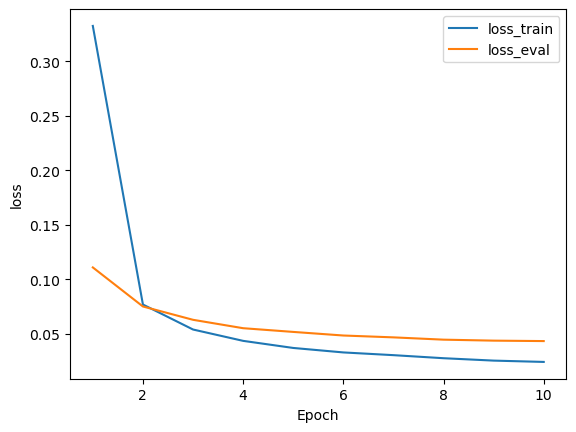

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_(epoch, loss_train,loss_eval):
    n_ep= np.arange(epoch)+1
    plt.plot(n_ep,loss_train)
    plt.plot(n_ep,loss_eval)
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.legend(["loss_train","loss_eval"])
    plt.show()

plot_(10, [0.3323 , 0.0770, 0.0541 , 0.0437, 0.0372,0.0331 , 0.0306 , 0.0278 , 0.0256, 0.0244],[0.1110, 0.0752, 0.0630, 0.0553, 0.0519,0.0486,0.0469, 0.0448,0.0439,0.0435]
)

In [3]:
n=217
n_test,n_eval= int(n*0.1),int(n*0.2)
print(n_test,n_eval)

21 43
